# Setup

In [1]:
import pandas as pd
import numpy as np
from tqdm import trange
from tqdm import tqdm
import tweepy
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import networkx as nx 
from networkx.algorithms import bipartite
from fa2 import ForceAtlas2

import chart_studio.plotly as py
import chart_studio.tools as tls

import cufflinks as cf
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline()

# Data import and processing

In [2]:
# Import cleaned and processed tweets
df_congress_tweets = pd.read_pickle('../Data/Processed/congress_cleaned_processed.pkl')

In [3]:
# Import media, twitter_handles and defining politician names
medias = pd.read_table('../Data/Raw/LargestMedia.csv', sep=';')
twitter_handles = pd.read_table('../Data/Processed/Twitter_Handles_updated.csv', sep = ',')
politician_names = twitter_handles['Name']

In [4]:
# Reconstruct media dataframe such that it can be concatenated with the dataframe containing the twitter handles
medias['State'] = None
medias['Party'] = None
medias['Type'] = 'Media'
medias.rename(columns={'Twitter name': 'Twitter', 'Media': 'Name'}, inplace=True)

In [5]:
# The merged dataframe
Data_Full = pd.concat([twitter_handles, medias])
Data_Full.head()

Twitter State       Party            Type           Name  \
0       JeffFlake    AZ  Republican         Senator     Jeff Flake   
1       SenJonKyl    AZ  Republican         Senator        Jon Kyl   
2  reppeteaguilar    CA    Democrat  Representative  Peter Aguilar   
3     repcardenas    CA    Democrat  Representative  Tony Cardenas   
4     DarrellIssa    CA  Republican  Representative   Darrell Issa   

   twitter_display_name  
0            Jeff Flake  
1  U.S. Senator Jon Kyl  
2     Rep. Pete Aguilar  
3    Rep. Tony Cárdenas  
4          Darrell Issa

We are only interested in the retweets made by the politicians - thus a new dataframe containing only politicians in the congress is created.  

In [6]:
# Filter
df_retweets = df_congress_tweets[df_congress_tweets['retweet'].isin(Data_Full.Twitter)]

user_id             user_name                  id          created_at  \
41    13218102   Senator John Cornyn  824779864175702016 2017-01-27 00:43:37   
165  137794015       Rep. Ted Deutch  824961188190629891 2017-01-27 12:44:08   
193   76649729  Sen. Lamar Alexander  824973693587771392 2017-01-27 13:33:50   
194   76649729  Sen. Lamar Alexander  824973693587771392 2017-01-27 13:33:50   
244   55677432    Bill Cassidy, M.D.  824986328156749825 2017-01-27 14:24:02   

                                                  text       retweet  \
41   miami dade mayor ends sanctuary status orders ...       FoxNews   
165  when you simply dont respect the united states...  RepTedDeutch   
193  @betsydevos is the person we need for this job...   SenatorBurr   
194  @betsydevos is the person we need for this job...   SenatorBurr   
244  from @politico devos vows to enforce special e...  SenAlexander   

     retweet_count  favorite_count  in_reply_to_status_id  in_reply_to_user_id  
41             863               0                    NaN                  NaN  
165             46               0                    NaN                  NaN  
193            177               0                    NaN                  NaN  
194            176               0                    NaN                  NaN  
244              4               0                    NaN                  NaN

We want to investigate who retweets whom and in order to get an overview, an adjacency matrix containing all politicians and media is created. Each row is a politician/media and the same goes for each column. 
First an adjacency matrix with zeros is initalized where rows and columns are defined as the names from the complete dataframe. 

In [7]:
# Initialize data frame
retweets_pd = pd.DataFrame(data = 0, index = Data_Full['Name'], columns = Data_Full['Name'])

It is interesting to investigate how many times politican has retweeted another politician or media which is why the adjacency matrix is created as a weighted matrix. Iterating through the complete dataframe `Data_Full` each index between a politician and another politician or media is incremented by 1 for every time there appears a retweet. 

In [8]:
# Populate dataframe
for idx, retweet in tqdm(df_retweets.iterrows(), total=len(df_retweets)):
    
    retweeter = retweet['user_name']
    original_poster = retweet['retweet'] 

    retweeter_name = Data_Full[Data_Full['twitter_display_name'] == retweeter]['Name'].values[0]
    original_poster_name = Data_Full[Data_Full['Twitter'] == original_poster]['Name'].values[0]

    retweets_pd.loc[retweeter_name, original_poster_name] += 1

100%|██████████| 72984/72984 [01:08<00:00, 1058.02it/s]


# Who retweets whom (MIKKEL - IKKE FÆRDIGT!)

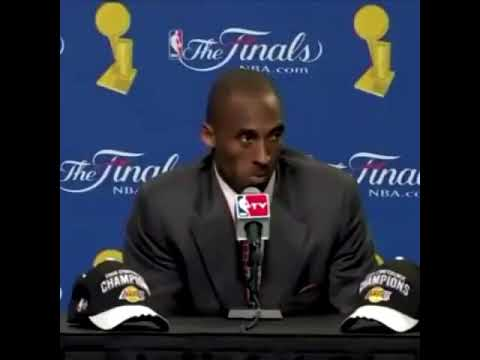

In [33]:
from IPython.display import YouTubeVideo
YouTubeVideo('aaplovE3vsg',width=800, height=450)

In [9]:
df_poltician_retweets = retweets_pd.loc[politician_names, politician_names]

# Create graph
G = nx.from_numpy_matrix(df_poltician_retweets.values, create_using=nx.DiGraph())

# Because we use numpy, labels need to be reset
label_mapping = {idx: val for idx, val in enumerate(df_poltician_retweets.columns)}
G = nx.relabel_nodes(G, label_mapping)

for node in G.nodes:
    G.nodes[node].update(df_poltician_retweets.loc[node])
UG = G.to_undirected() 

# Get isolates
nodes_to_remove = list(nx.isolates(UG))
UG.remove_nodes_from(nodes_to_remove)

# Show how many are removed
print(f"{len(nodes_to_remove)} nodes removed as they are isolates")

26 nodes removed as they are isolates


### Basic stats of the Graph

In [10]:
# Nodes
print(f'The graph has {len(G.nodes)} nodes in total')

# Edges
print(f'There are a total of {len(G.edges)} edges in the data set.')

The graph has 618 nodes in total
There are a total of 18854 edges in the data set.


In [11]:
df_sum_tweets = (df_poltician_retweets.sum(axis=0)
    .to_frame()
    .rename(columns = {0: 'Sum of retweets'})
    .assign(in_degree = [in_degree for name, in_degree in G.in_degree()])
    .assign(out_degree = [out_degree for name, out_degree in G.out_degree()])
)
df_sum_tweets

Sum of retweets  in_degree  out_degree
Name                                                   
Jeff Flake                   103         36           4
Jon Kyl                        0          0           0
Peter Aguilar                  0          0           8
Tony Cardenas                  0          0          44
Darrell Issa                  12          9          10
...                          ...        ...         ...
Mike Gallagher                 0          0           0
Mike Enzi                     28         15           7
John Barrasso                 45         17          13
Liz Cheney                    44         20          11
Donald J. Trump             3160        211          77

[618 rows x 3 columns]

In [12]:
px.histogram(
    df_sum_tweets,
    x = 'Sum of retweets'
)

In [13]:
fig = px.histogram(
    df_sum_tweets,
    x = ['in_degree', 'out_degree'],
    barmode="overlay"
)
fig

In [14]:
px.scatter(
    df_sum_tweets,
    y = ['in_degree', 'out_degree'],
)

In [15]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence = 0.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=5.0,
    gravity=1.0,

    # Log
    verbose=True
)


# Calculate positions
positions = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:11<00:00, 173.93it/s]BarnesHut Approximation  took  1.62  seconds
Repulsion forces  took  8.07  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  1.23  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds



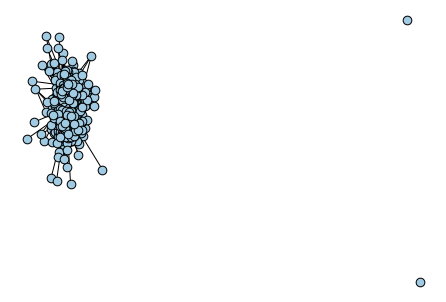

In [16]:
# Draw simple graph
nx.draw_spring(
    G = UG, 
    node_size = 75, 
    node_color = '#A0CBE2', 
    node_shape = 'o',
    edge_color = 'k',
    with_labels = False, 
    edgecolors='k') 
plt.draw()

# Retweets of media visualized as a Bipartite graph

A bipartite graph is a network constructed by two disjoint sets where the nodes in the network are divided into these sets. Bipartite graphs are very useful when modelling relationships between two different classes. In this analysis we will focus on how the political polarization is expressed in retweets of the 16 largest media contained in data. This means that the network is constituted by a set containing the media and a set containing the politicians. Each link in the network connects a media-node to a politician-node.

Since we are interested in the relationship between media and politicians, we need to modify the adjacency matrix containing information about retweets. This is done by forcing all weights between politicians and another politicians to zero while the weights between politicians and media are retained. 

In [17]:
# Modified retweet adjacency matrix
retweets_pd.loc[politician_names, politician_names] = 0
retweets_pd.head()

Name           Jeff Flake  Jon Kyl  Peter Aguilar  Tony Cardenas  \
Name                                                               
Jeff Flake              0        0              0              0   
Jon Kyl                 0        0              0              0   
Peter Aguilar           0        0              0              0   
Tony Cardenas           0        0              0              0   
Darrell Issa            0        0              0              0   

Name           Darrell Issa  Steve Knight  Dana Rohrabacher  Ed Royce  \
Name                                                                    
Jeff Flake                0             0                 0         0   
Jon Kyl                   0             0                 0         0   
Peter Aguilar             0             0                 0         0   
Tony Cardenas             0             0                 0         0   
Darrell Issa              0             0                 0         0   

Name           David Valadao  Mike Coffman  ...  Bloomberg  \
Name                                        ...              
Jeff Flake                 0             0  ...          0   
Jon Kyl                    0             0  ...          0   
Peter Aguilar              0             0  ...          0   
Tony Cardenas              0             0  ...          0   
Darrell Issa               0             0  ...          0   

Name           The New York Times  USA Today Politics  Breitbart News  TIME  \
Name                                                                          
Jeff Flake                      0                   0               0     0   
Jon Kyl                         0                   0               0     0   
Peter Aguilar                   0                   0               0     0   
Tony Cardenas                   1                   0               0     0   
Darrell Issa                    0                   0               0     0   

Name           The Hill  POLITICO  The Wall Street Journal  The Economist  \
Name                                                                        
Jeff Flake            0         0                        0              0   
Jon Kyl               0         0                        0              0   
Peter Aguilar         0         0                        0              0   
Tony Cardenas         0         1                        0              0   
Darrell Issa          1         0                        0              0   

Name           HuffPost  
Name                     
Jeff Flake            0  
Jon Kyl               0  
Peter Aguilar         0  
Tony Cardenas         0  
Darrell Issa          0  

[5 rows x 634 columns]

Next step is to visualize the network as a bipartite graph. As for the 'Who-Retweets-Whom'-graph, a simple graph is created based on the adjacency matrix where the nodes are labeled using the names. To get an overview of the retweets, the simple graph is visualized. 

In [18]:
# Create graph
B = nx.from_numpy_matrix(retweets_pd.values, create_using=nx.Graph())

# Make label mapping for relabeling nodes
label_mapping = {idx: val for idx, val in enumerate(retweets_pd.columns)}
B = nx.relabel_nodes(B, label_mapping)

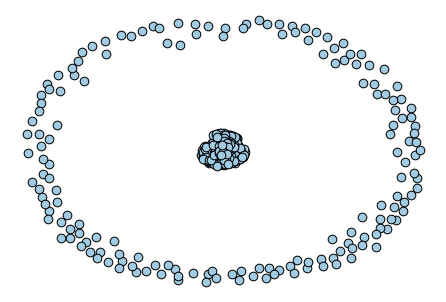

In [19]:
# Draw simple graph
nx.draw_spring(
    G = B, 
    node_size = 75, 
    node_color = '#A0CBE2', 
    node_shape = 'o',
    edge_color = 'k',
    with_labels = False, 
    edgecolors='k') 
plt.draw()

From the visualization it can be seen that in the periphery are the politicians that have not retweeted any media. Thus, the interesting part of the graph is the giant connected component and the remaining nodes will be ignored.

In order to create a bipartite graph for the giant connected component, we must ensure that it is connected. 

In [20]:
# Extract GCC
con_comp = sorted(nx.connected_components(B), key = len, reverse = True)
B_GCC = B.subgraph(con_comp[0]).copy()

# Very connectivity
nx.is_connected(B_GCC)

True

Since the GCC is connected, we can create the two sets for the bipartite graph. For every node we can extract information about their type - i.e. does the node belong to the type 'Media' or does it belong to 'Senator', 'Representative' and 'POTUS'. If the node represents a politician it will get the attribute `bipartite` with value 0. The same is done for the nodes that represent a media - the value for attribute `bipartite` is set to 1. 

In [21]:
# Create two sets for the bipartite graph
for node in B_GCC.nodes:
    
    node_info = Data_Full[Data_Full['Name'] == node]

    # If politician
    if node_info['Type'].values[0] != 'Media':
        B_GCC.nodes[node].update({
            bipartite: 0
        })
        
    # If media
    elif  node_info['Type'].values[0] == 'Media':
         B_GCC.nodes[node].update({
            bipartite: 1
         })

The two sets 'Politicians' and 'Media' are then defined. 

In [22]:
# Get node sets 
B_GCC_politicians = [node for node, value in B_GCC.nodes(data=bipartite) if value == 0]
B_GCC_medias = [node for node, value in B_GCC.nodes(data=bipartite) if value == 1]

The positions of the nodes for both sets are determined using `networkX` build-in function for drawing bipartite graphs. The function outputs the name of the node with the corresponding $x-$ and $y-$coordinates. For better interpretation, the positions of the politicians are sorted after party - 'Republican', 'Libertarian', 'Independent' and 'Democrat'. This is done by sorting the nodes after party and by saving the $y-$coordinate for each politician we can modify the coordinates according to their 'party-position'. The new positions for the politicians are merged with the positions for the media in order to draw the correct edges when drawing the bipartite graph. 

In [23]:
# Determine positions on graph for politicans and medias respectively
positions_init = nx.drawing.layout.bipartite_layout(B_GCC, B_GCC_politicians)
position_pol = {node: pos for node, pos in positions_init.items() if node in B_GCC_politicians}
position_media = {node: pos for node, pos in positions_init.items() if node in B_GCC_medias}

# Save y-coordinates for postion of politicians
y_list = np.linspace(min([v[1] for k,v in position_pol.items()]), max([v[1] for k,v in position_pol.items()]), len(position_pol))

# Get politician list
list_of_politican = [list(Data_Full[Data_Full['Party'] == party]['Name']) for party in ['Republican','Libertarian','Independent','Democrat']]

# Sort politicians after party
ordered_politicians = []
for sublist in list_of_politican:
    for item in sublist:
        ordered_politicians.append(item)

# We only want to use the politicians contained in the GCC
politician_GCC = [politician for politician in ordered_politicians if politician in list(B_GCC.nodes)]

# New positions for politicians
new_positions_politicians = pd.DataFrame(list(zip(politician_GCC, [v[0] for k,v in position_pol.items()], y_list)), 
               columns =['Name', 'x', 'y'])
new_pos_pol_dict = new_positions_politicians.set_index('Name').T.to_dict('list')

# Save all positions
new_positions = {**new_pos_pol_dict, **position_media}

Another important feature for the graph is the color of the nodes. The same colors used in the 'Who-Follows-Whom' graph are used. Furthermore the media nodes are colored based the fraction of democratic links. A custom color scale will be defined going from red to blue over purple as the fraction goes from 0 to 1. Here we *ignore* the very few Liberatarian and Independents in this color scale and as such we do make an assumption that they are Republican in regards to the coloring as we only look at the Democratic factor. As there are so few nodes of Liberatarian and Independents it is seemed as insignificant compared to the fact that the variable node coloring is quite cool.

In [24]:
color_dict_party = {"Democrat": "#0015BC", "Republican": "#DE0100", 'Independent': "tab:gray", 'Libertarian': "#FED105"}
node_colors = [color_dict_party[Data_Full.loc[Data_Full.Name == key, 'Party'].values[0]]
                for key, value in new_pos_pol_dict.items() if Data_Full.loc[Data_Full.Name == key, 'Party'].values[0] is not None]

In [25]:
# Media color
media_count = {media: {'Republican' : 0, 'Democrat' : 0, 'Independent' : 0 , 'Libertarian' : 0}  for media in medias.Name}
politian_party = {politican:party for politican, party in zip(Data_Full.Name, Data_Full.Party)}

for edge, count in nx.get_edge_attributes(B_GCC,'weight').items():
    politicans, media = edge
    
    party = politian_party[politicans]
    media_count[media][party] += count


Democrat_frac_dict = {nm: weights['Democrat']/sum(weights.values()) for nm,weights in media_count.items()}

# Color dict values
cdict = {'red':   ((0.0, 1.0, 1.0), 
                   (0.1, 1.0, 1.0),  # red 
                   (0.4, 1.0, 1.0),  # violet
                   (1.0, 0.0, 0.0)), # blue

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.1, 0.0, 0.0),  # red
                   (0.4, 1.0, 1.0),  # violet
                   (1.0, 1.0, 0.0))  # blue
          }

# Function for color map
def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

# Make colormap
c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('red'), c('violet'), 0.44, c('violet'), c('blue'), 1, c('blue')])

The bipartite graph is drawed such that the nodes from the two sets, Politicians and Media, are created firstly with the correct positions and colors. Herefter, the links are added where the width are determined by $\frac{1}{10} \cdot w$, where $w$ is the weight from the adjacency matrix. We have made some experiment to find the scaling factor to make the plot looks good.

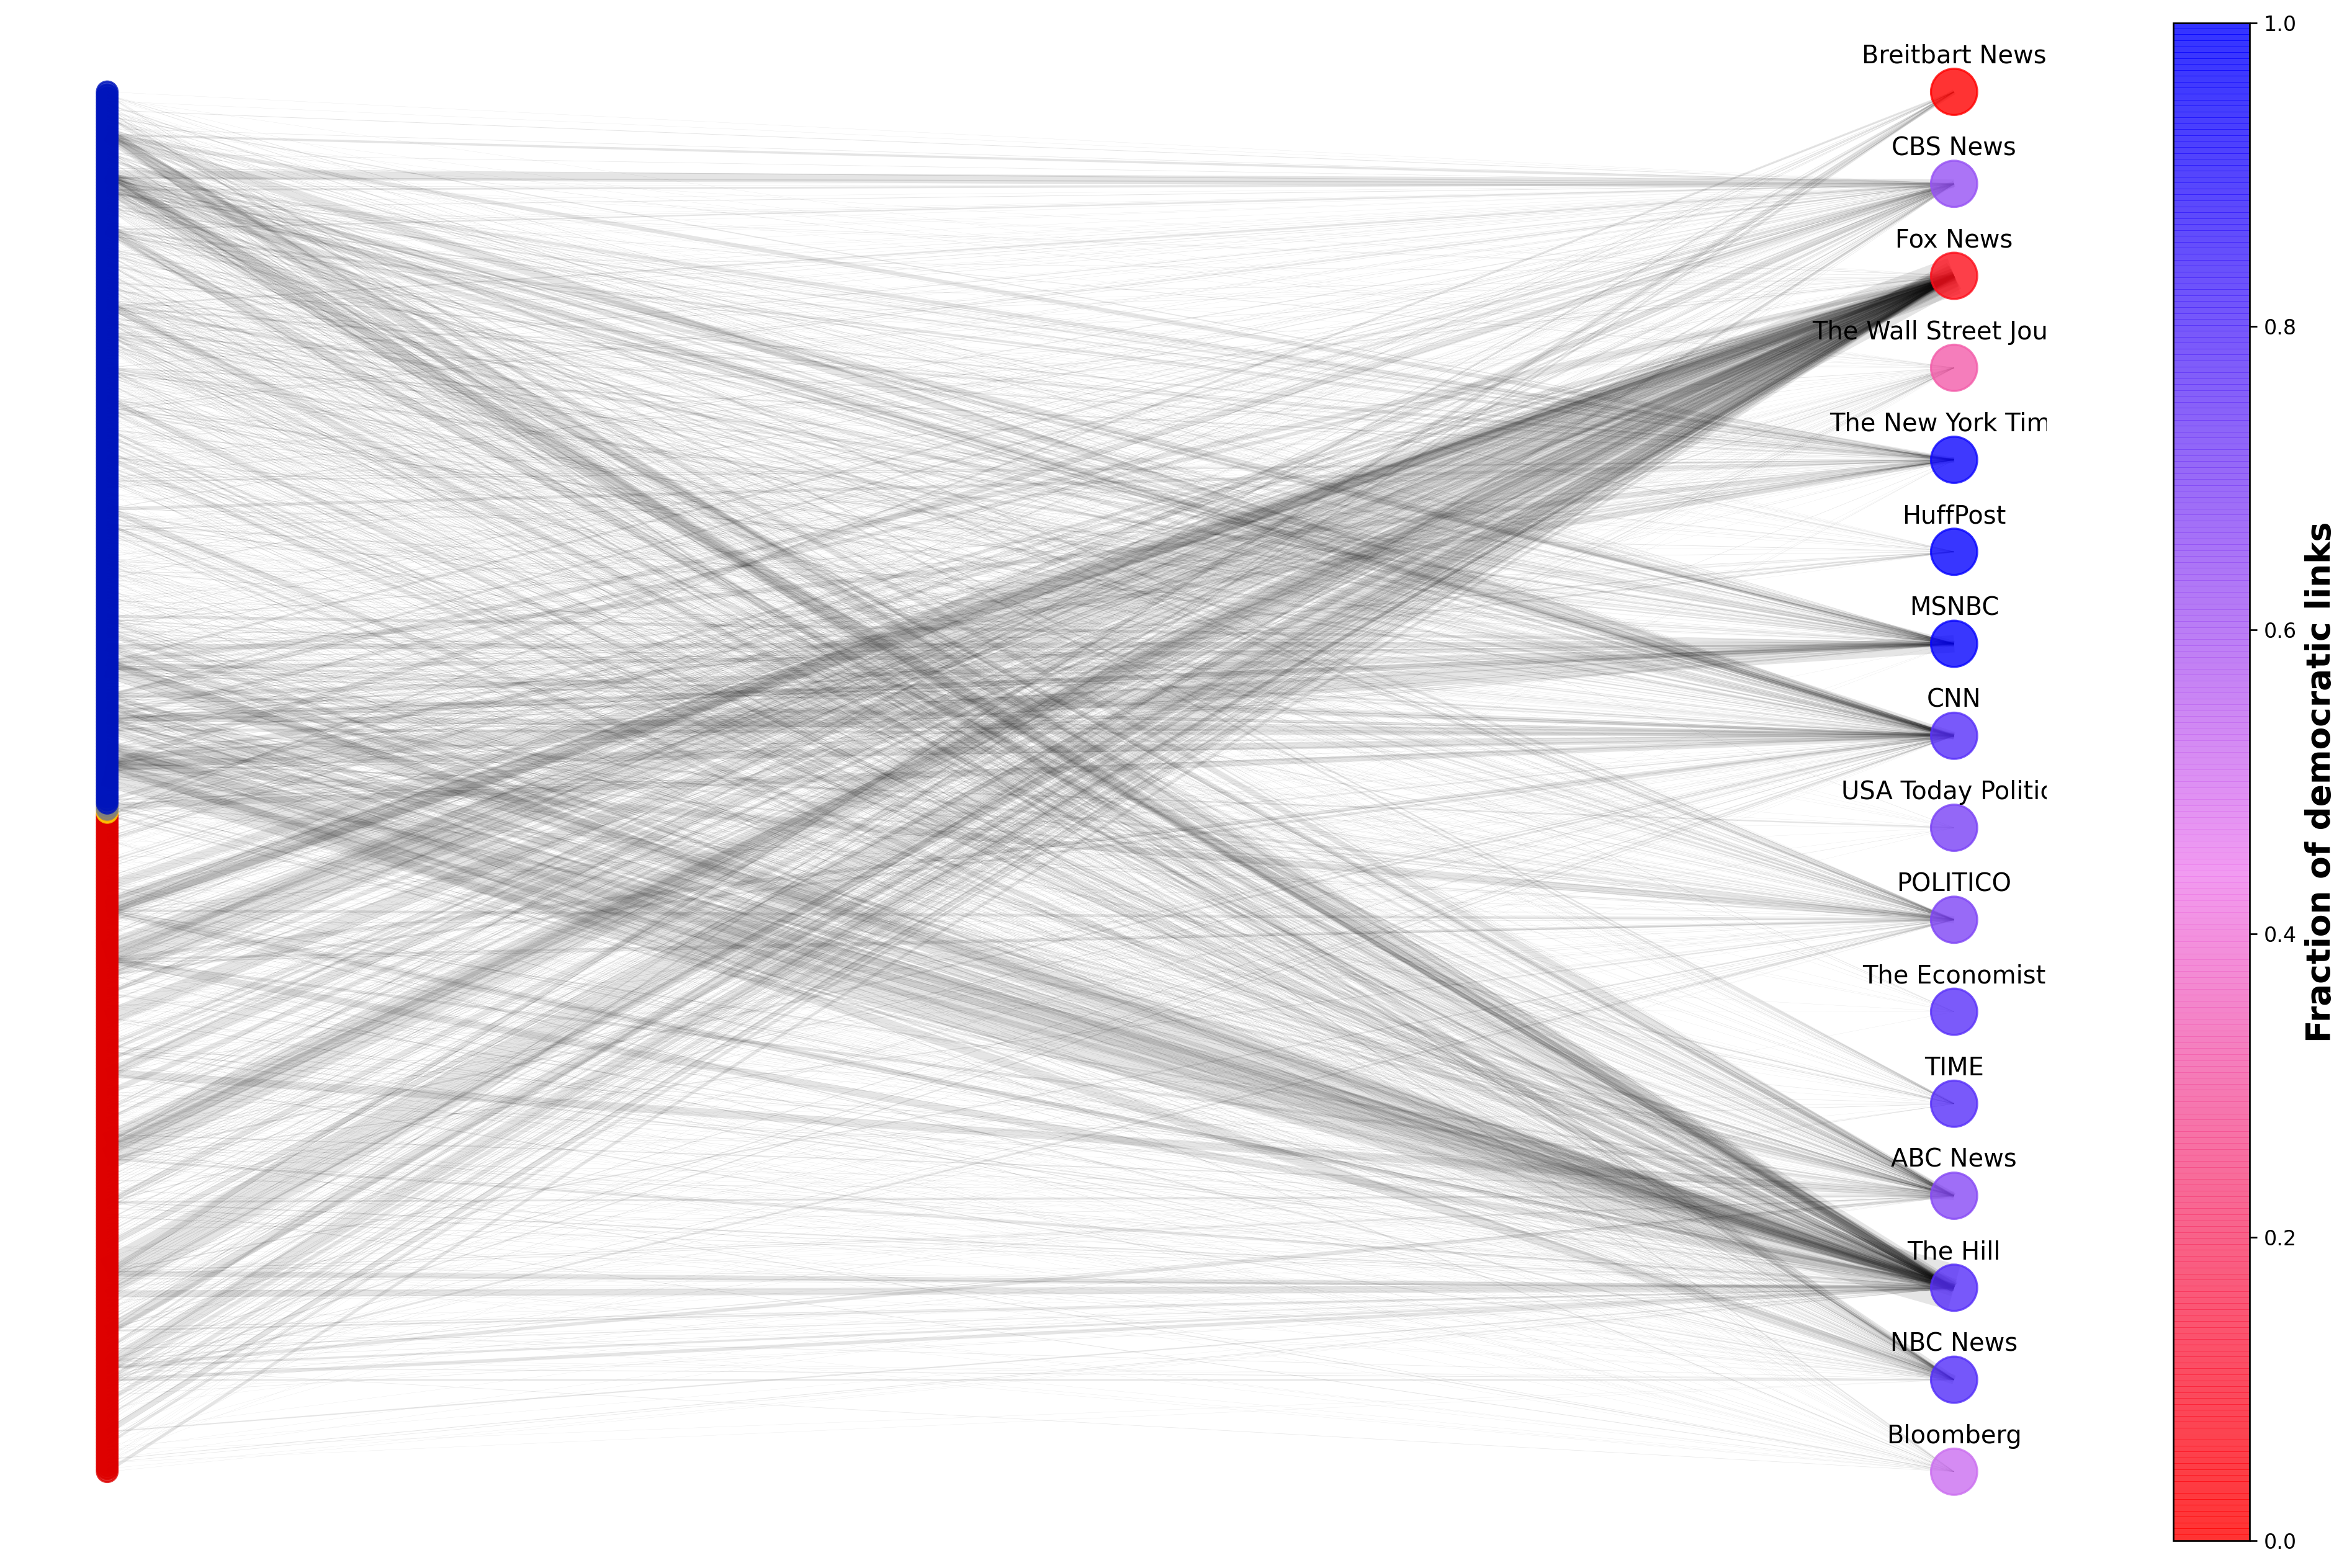

In [26]:
plt.figure(figsize=(22,13.5), dpi = 240)

# Media nodes
nodes_media = nx.draw_networkx_nodes(B_GCC, position_media,
                       nodelist=position_media.keys(),
                       node_color=[Democrat_frac_dict[nm] for nm in position_media.keys()],
                       cmap = rvb,
                       node_size=500,
                   alpha=0.8)

# Politician nodes
nodes_pol = nx.draw_networkx_nodes(B_GCC, new_pos_pol_dict,
                       nodelist=new_pos_pol_dict.keys(),
                       node_color= node_colors,
                       node_size=100,
                   alpha=0.8)

# Edges
edges = nx.draw_networkx_edges(
    G = B_GCC,
    pos = new_positions,
    edgelist = B_GCC.edges(),
    width = [i/10 for i in list(nx.get_edge_attributes(B_GCC,'weight').values())],
    alpha=0.1
)

# Position of labels on media
pos_higher = {}
for k, v in position_media.items():
        pos_higher[k] = (v[0], v[1]+0.02)

labels={key: key for key, value in position_media.items()}
nx.draw_networkx_labels(B_GCC, pos_higher, labels)
#nx.draw_networkx_labels(B_GCC, position_media, labels)
plt.colorbar(nodes_media).set_label(label='Fraction of democratic links',size=16,weight='bold')
nodes_media.set_clim(0, 1)
plt.axis('off')
plt.show()

From data it is known that the majority of the politicians belongs to either Republicans or Democrats which is also clearly seen in the set to the left. The bipartite graph shows that Fox News is primarily retweeted by Republican Party politicians and from the width of the links it can be seen that these politicians retweeted Fox News several times. Breitbart News is also retweeted mostly by republicans, however there are fewer links between the politicans to BreitBart News. 

The Hill and CNN are predominantly blue based on the retweets. Both have probably been retweeted by republicans but as seen on the colorscale it is the Democrats who make up the majority of the retweets. Cf. the clip from YouTube presented in Project Assignment A, it is interesting that the CNN node is not colored all blue. An explanation could be that CNN is not as politically polarized as, for example, Fow News is. 

Overall, the bipartite graph clearly shows that the media form part of the political polarization which supports our overall problem. 

## Statistics

With the bipartite graph it is interesting to investigate statistics such as the distribution of links to each media and also if there exist a so-called butterfly pattern in the graph. I.e. is there a tendency for politicians from the same party to retweet the same media. Another interesting analysis is of the existence of clustering of the media by a clustering coefficient. 


For the investigation of the link distribution for each media, a grouped barplot is created such that the four parties are illustrated as fours bars for each of the media with the corresponding count of retweets. 


In [27]:
# Create four lists for bars in grouped barplot
Republican = [media_count[media]['Republican'] for media, count in media_count.items()]
Libertarian = [media_count[media]['Libertarian'] for media, count in media_count.items()]
Independent = [media_count[media]['Independent'] for media, count in media_count.items()]
Democrat = [media_count[media]['Democrat'] for media, count in media_count.items()]

In [28]:
fig = go.Figure(data=[
    go.Bar(name='Republicans', x=medias['Name'], y=Republican, text=Republican, marker_color='#DE0100', width=0.5),
    go.Bar(name='Independents', x=medias['Name'], y=Independent, text=Independent, marker_color='#7f7f7f', width=0.5),
    go.Bar(name='Libertarians', x=medias['Name'], y=Libertarian, text=Libertarian, marker_color='#FED105', width=0.5),
    go.Bar(name='Democrats', x=medias['Name'], y=Democrat, text=Democrat, marker_color='#0015BC', width=0.5)
])

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(barmode='group',margin=dict(b=5,l=5,r=5,t=40),
    titlefont_size=16, uniformtext_minsize=8, autosize=False,
    width=1000, height=500, bargap=0.2, bargroupgap=0.2)
# save for website
fig.write_html(
    file = "../web_app/plotly_files/Bipartite_grouped_barplot.html", 
    full_html = False,
    include_plotlyjs='cdn'
)
fig.show()

The media that are retweeted the most are CNN, Fox News, MSNBC, The New York Times and The Hill where The Hill and Fox News have been retweeted a lot during the given period. The figure shows some quite interesting - namely that the majority of the politicans that have retweeted The Hill are democrats. It also shows that Fox News have been retweeted by republicans, as expected. 


A build-in function in the `bipartite` subpackage of `networkX` is the Robins-Alexander bipartite clustering coefficent. This coefficent calculates the probability that a bipartite caterpillar participates in a bipartite butterfly. This can be translated to the probability that politicians from same party retweet the same media. 

The coefficent is given by $$c = \frac{4\times n^{\bowtie}}{n^{\mathsf{z}}} =\frac{4 \times (\text{total number of butterflies})}{\text{total number of caterpillars}}.$$ 

The factor of 4 comes from the fact that there are four caterpillars in a butterfly.
(ref. to https://arxiv.org/pdf/1607.08673.pdf)

In [29]:
# Calculate coefficient
bipartite.robins_alexander_clustering(B_GCC)

0.44215420474544737

From the coefficient it can be interpreted that 44\% of the caterpillars become butterflies in our bipartite graph. As we only have one graph it is hard to put this number in to comparison but in looks like there could be a tendency for politicians from the same party to retweet the same media.

Another clustering method in the `bipartite` package is the bipartite clustering coefficient that measures the degree to which nodes in a graph tend to cluster together. It is defined $$c_u = \frac{\sum_{v \in N(N(u))} \ c_{uv}}{|N(N(u))|}$$ (ref. til https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.cluster.clustering.html). 

The clustering coefficient is calculated for all the 16 media

In [30]:
bipartite.clustering(B_GCC, nodes = medias['Name'])

{'ABC News': 0.23316120974611895,
 'CBS News': 0.23728258674830552,
 'CNN': 0.25139003621850825,
 'Fox News': 0.1382284245582041,
 'MSNBC': 0.2248332821772454,
 'NBC News': 0.2270067974812666,
 'Bloomberg': 0.13443336361389543,
 'The New York Times': 0.22280465199578975,
 'USA Today Politics': 0.05825873525719665,
 'Breitbart News': 0.06798366736573926,
 'TIME': 0.14223120191809238,
 'The Hill': 0.24999941239863788,
 'POLITICO': 0.24018246218069983,
 'The Wall Street Journal': 0.1368549606726121,
 'The Economist': 0.059795763376332155,
 'HuffPost': 0.12262269455134579}

Here a large varity of number are seen. Some of the classic large American news media scores high here which fits well with fomula - they are way more *connected*.

The bipartite graph is used to investigate the media's contribution to the political polarization, if they have any. By dividing a simple graph containing all nodes into two sets - one for media, one for politicians - it can be concluded that based on retweets, the media have a part in the political polarization.  